In [1]:
import BOCD
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
import warnings
import random
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.cm as cm
from Htests import online, Mood
import math
from itertools import cycle
from ruptures.utils import pairwise
import ruptures as rpt

# Offline Ruptures Demo

In [2]:
from math import log
from ruptures.base import BaseCost
from numpy.linalg import inv
from numpy.linalg import det
import ruptures as rpt

# Cost function 3 in Truong, Charles & Oudre, Laurent & Vayatis, Nicolas. (2018). A review of change point detection methods. 
# Changes in mean and variance of gaussian data

class MyCost(BaseCost):

    """Custom cost"""

    # The 2 following attributes must be specified for compatibility.
    model = ""
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        sub = self.signal[start:end]
        
        mean = sub.mean()
        var = sub.var()
        
        return len(sub)*log(var) + ((sub-mean)**2).sum()/var

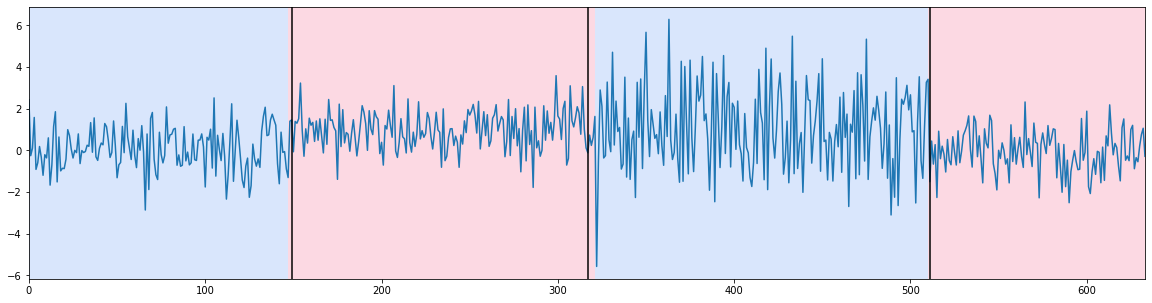

In [3]:
np.random.seed(5)

l1 = np.random.randint(low = 50, high = 200)
l2 = np.random.randint(low = 50, high = 200)
l3 = np.random.randint(low = 50, high = 200)
l4 = np.random.randint(low = 50, high = 200)

a = np.random.normal(size = l1)
b = np.random.normal(loc = 1, size = l2)
c = np.random.normal(loc = 1, scale = 2, size = l3)
d = np.random.normal(loc = 0, scale = 1, size = l4)

signal = np.concatenate((a, b, c, d))


# cost
algo = rpt.Pelt(custom_cost=MyCost(), jump = 1).fit(signal)
cps = [cp - 1 for cp in algo.predict(pen=15)]
cps.pop(-1)
cps = np.insert(cps, 0, 0)
bkps = sorted(cps)
bkps = np.insert(bkps, len(bkps), len(signal) - 1)
actual_cps = np.array([l1, l1+l2, l1+l2+l3])

# plotting
color_cycle = cycle(["#4286f4", "#f44174"])

fig, (ax1) = plt.subplots(1, 1, figsize = (20, 5))
ax1.margins(x=0)

ax1.plot(signal)

for (start, end), col in zip(pairwise(bkps), color_cycle):
    ax1.axvspan(start, end, facecolor=col, alpha=0.2)

for y in actual_cps:
    ax1.axvline(x = y, color = 'black')

plt.show()

# BOCD Demo

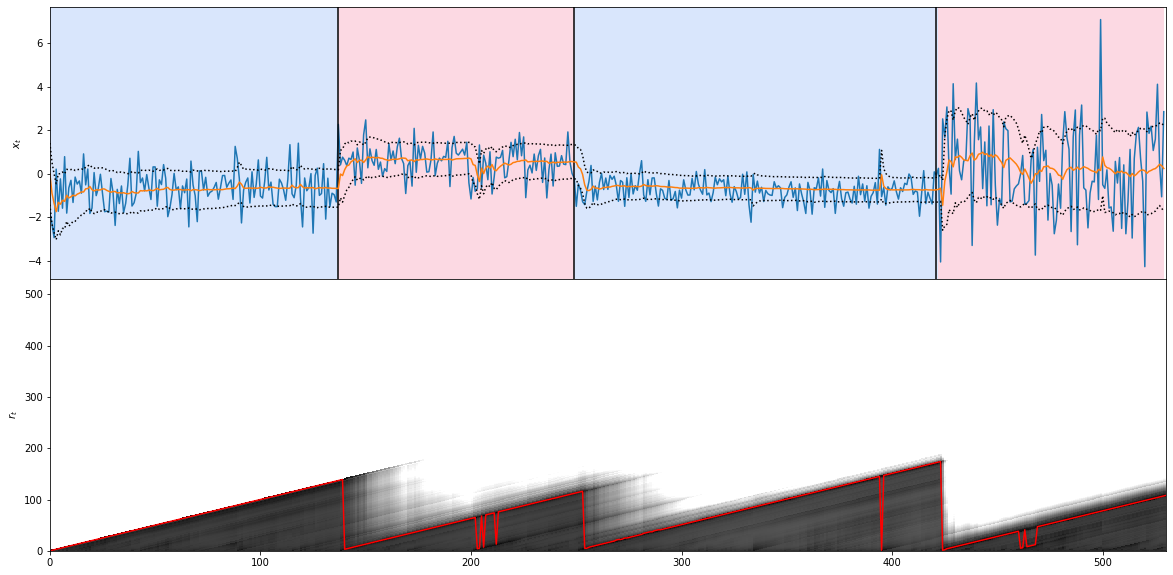

In [4]:
np.random.seed(1)
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.normal()*1
        scale = np.random.normal()*2
        if scale < 0:
            scale = scale * -1
        tdata = np.random.normal(mean, scale, p)
        data = np.concatenate((data, tdata))
    return data, partition

data, partition = generate_normal_time_series(4, 100, 200)
actual_cps = partition.cumsum()[:-1]
R, cps, maxes_R, pred_mean, pred_var = BOCD.online_changepoint_detection(data, partial(BOCD.constant_hazard, 100), BOCD.GaussianUnknownMeanVar(1, 1, 1, 0))

bkps = sorted(cps) + [len(data)-1]
# plotting
color_cycle = cycle(["#4286f4", "#f44174"])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 10), sharex = True)
ax1.margins(x=0)
ax1.set_ylabel(r'$x_t$')
ax2.margins(x=0)
ax2.set_ylabel(r'$r_t$')
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
ax1.plot(data)

for (start, end), col in zip(pairwise(bkps), color_cycle):
    ax1.axvspan(start, end, facecolor=col, alpha=0.2)

for y in actual_cps:
    ax1.axvline(x = y, color = 'black')
sparsity = 1
ax2.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0::sparsity, 0::sparsity]), 
          cmap=cm.gray, vmin=0, vmax=30)

ax2.plot(maxes_R, color = 'Red')

ax1.plot(pred_mean[:-1])
ax1.plot(pred_mean[:-1] + np.sqrt(pred_var[:-1]), linestyle = ':', color = 'black')
ax1.plot(pred_mean[:-1] - np.sqrt(pred_var[:-1]), linestyle = ':', color = 'black')

plt.show()

# HTest Demo

In [5]:
# Import thresholds
Mood_500 = np.genfromtxt('Mood500.txt')

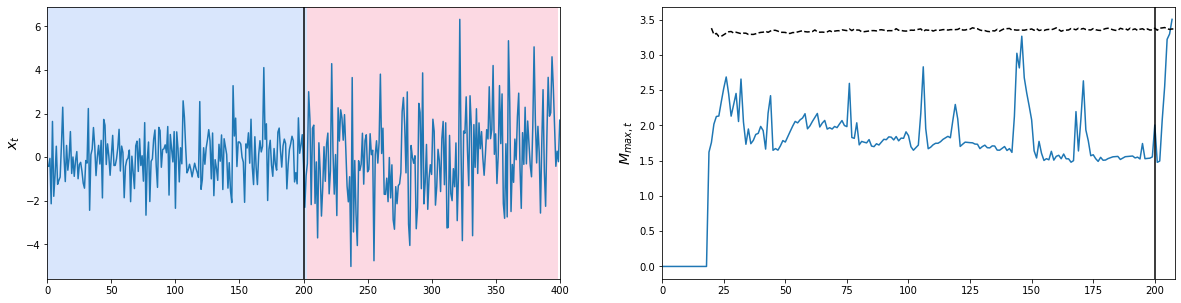

In [8]:
np.random.seed(2)
data = np.concatenate((np.random.normal(size = 200), np.random.normal(scale = 2, size = 200)))
cps,  detected, change_type = online(data,  Mood, Mood_500)
statistics = []
for i in range(19):
    statistics.append(0)
    

for i in range(20, detected[1] + 2):
    window = data[:i]
    _, D = Mood(window)
    statistics.append(D)
    
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20 + 0.2, 5))
fig.subplots_adjust(wspace=0.2)
ax1.margins(x=0)
color_cycle = cycle(["#4286f4", "#f44174"])
bkps = sorted(cps) + [len(data) - 1]

ax1.plot(range(1, len(data) + 1), data)
for (start, end), col in zip(pairwise(bkps), color_cycle):
    ax1.axvspan(start, end, facecolor=col, alpha=0.2)

ax1.set_ylabel(r'$x_t$', size = 14)
    
ax1.axvline(x = 200, color = 'Black')

bkps = sorted(cps) + [detected[1] + 2 - 1]
ax2.margins(x = 0)
ax2.plot(statistics)
ax2.plot(range(20, detected[1] + 2), Mood_500[19:detected[1] + 1], color = 'Black', linestyle = "--")
ax2.axvline(x = 200, color = 'Black')
ax2.set_ylabel(r'$M_{max, t}$', size = 14)
plt.show()

